# Self-Driving Car Engineer Nanodegree
## Project: Advanced Lane Finding


# Camera calibration

In the following code camera calibration is performed. The code is based on [Udacity's](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb) example.

In [1]:
# Load necessary modules and set up
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

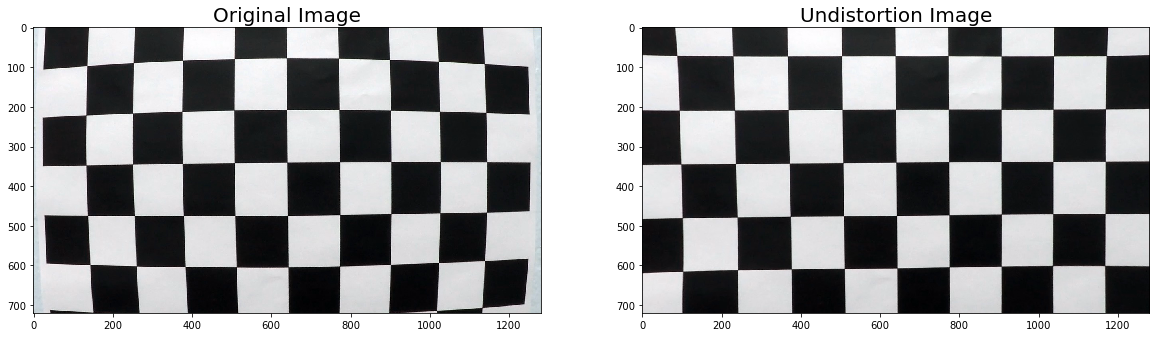

In [2]:
# prepare object points
nx = 9
ny = 6

# Make a list of calibration images
images = glob.glob('./camera_cal/cali*.jpg')

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name ='./output_images/camera_cal/'+'corners_found'+str(idx+1)+'.jpg'
        cv2.imwrite(write_name, img)


# Test undistortion on a calibration image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

dst = cv2.undistort(img, mtx, dist, None, mtx)

write_name ='./output_images/camera_cal/undistortied_calibration1.jpg'
cv2.imwrite(write_name, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistortion Image', fontsize=20)

# Pipeline (test images)

## Distortion correction that was calculated via camera calibration applied to each test image. 

cameraMatrix: [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
distCoeffs: [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


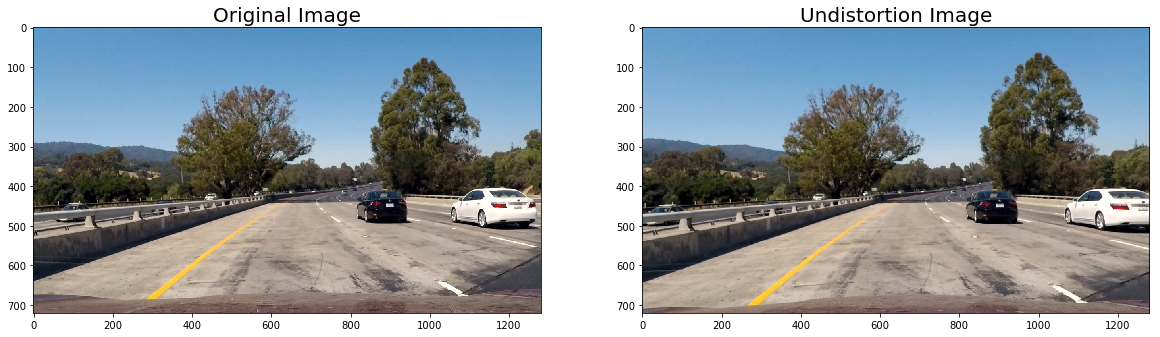

In [48]:
# Undistortion test images

# Load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

print('cameraMatrix:', mtx)
print('distCoeffs:', dist)

# Read the list of test images
test_images = glob.glob('./test_images/test*.jpg')

for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    write_name = './output_images/test_images/'+'undistorted'+str(idx+1)+'.jpg'
    cv2.imwrite(write_name, dst)
    
# Test undistortion on an test image
img_test1 = mpimg.imread('test_images/test1.jpg')
dst_test1 = mpimg.imread('output_images/test_images/undistorted1.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_test1)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst_test1)
ax2.set_title('Undistortion Image', fontsize=20)

## Create of thresholded binary image

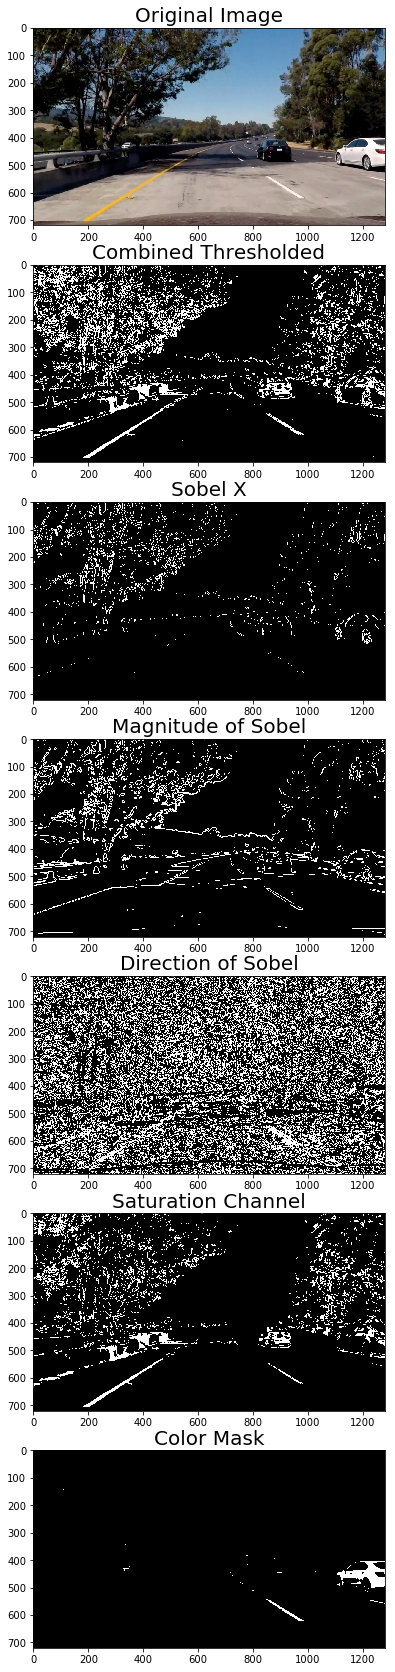

In [43]:
# Binary Image
# Sobel gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with sobel function and take the absolute value
    if orient == 'x':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        abs_sobel = 0
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a copy and apply the threshold
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sobel_binary

# Magnitude of Sobel gradient
def mag_sobel_thresh(img, sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Tkae both sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit interger
    scaled_gradmag = np.uint8(255 * gradmag / np.max(gradmag))
    # Create a copy and apply the threshold
    gradmag_ninary = np.zeros_like(scaled_gradmag)
    gradmag_ninary[(scaled_gradmag >= thresh[0]) & (scaled_gradmag <= thresh[1])] = 1

    return gradmag_ninary

# Direction of Sobel gradient
def dir_sobel_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    graddir_binary = np.zeros_like(absgraddir)
    graddir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return graddir_binary

# Binary saturation channel threshold
def s_thresh(img, thresh=(0,255)):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

    return s_binary

# Color in range
def color_thresh(img):
    
    yellow_lower = np.array([200, 200, 0])
    yellow_upper = np.array([255, 255, 255])
    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(img, yellow_lower, yellow_upper)
        
    return mask

# Combine grandient and color binary
def combined_thresh(img):
    
    mask = color_thresh(img)  # Get yellow and white region
    absx_bin = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(40,150))
    mag_bin = mag_sobel_thresh(img, sobel_kernel=9, thresh=(50,120))
    dir_bin = dir_sobel_thresh(img, sobel_kernel=15, thresh=(0.7,1.3))
    
    s_bin = s_thresh(img, thresh=(150,255))
    
    combined = np.zeros_like(absx_bin)
    # Sobel threshold result firstly bitand with color mask
    combined[((mask == 1) | ((absx_bin == 1) |
             ((mag_bin == 1) & (dir_bin == 1)))) | 
             (s_bin == 1)] = 1
    
    return combined, absx_bin, mag_bin, dir_bin, s_bin, mask


# Read in an undistortion image
image_undistorted = mpimg.imread('output_images/test_images/undistorted5.jpg')

# Run the function
combined_test, absx_bin, mag_bin, dir_bin, s_bin, color_mask = combined_thresh(image_undistorted)

# Plot the result
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(24, 25))

ax1.imshow(image_undistorted)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined_test, cmap='gray')
ax2.set_title('Combined Thresholded', fontsize=20)
ax3.imshow(absx_bin, cmap='gray')
ax3.set_title('Sobel X', fontsize=20)
ax4.imshow(mag_bin, cmap='gray')
ax4.set_title('Magnitude of Sobel', fontsize=20)
ax5.imshow(dir_bin, cmap='gray')
ax5.set_title('Direction of Sobel', fontsize=20)
ax6.imshow(s_bin, cmap='gray')
ax6.set_title('Saturation Channel', fontsize=20)
ax7.imshow(color_mask, cmap='gray')
ax7.set_title('Color Mask', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
# Read the list of test images
undistorted_images = glob.glob('./output_images/test_images/undistorted*.jpg')

for idx, fname in enumerate(undistorted_images):
    img = mpimg.imread(fname)
    combined, absx_bin, mag_bin, dir_bin, s_bin, color_mask = combined_thresh(img)

    write_name = './output_images/test_images/'+'binary_test'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, combined, cmap='gray')

## Perspective transform to a bird-eye view

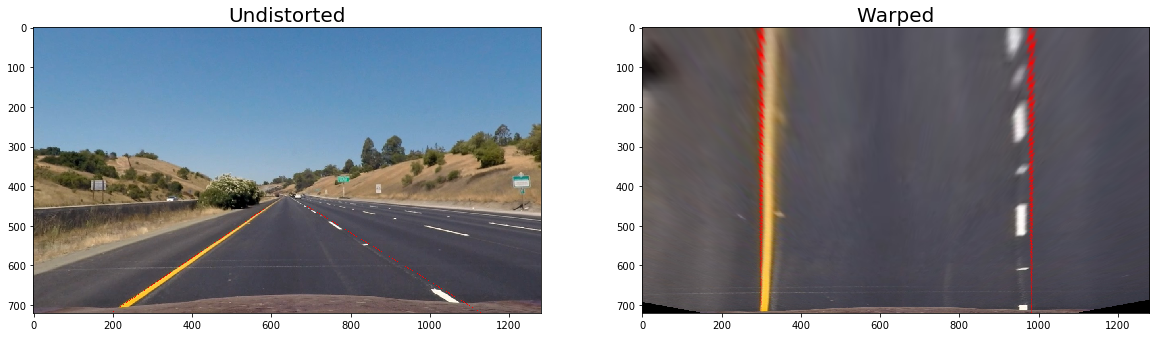

In [6]:
# Compute the perspective transform and warp the images
def perspective_transform(img):

    img_size = (img.shape[1], img.shape[0])
    # Four source coordinates
    src = np.float32(
        [[196, 720],
         [1130, 720],
         [593, 450],
         [690, 450]])
    # Four desired coordinates
    dst = np.float32(
        [[300, 720],
         [980, 720],
         [300, 0],
         [980, 0]])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Create warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

def draw_straight_line(img):
    
    cv2.line(img, (196, 720), (593, 450), color=(255,0,0), thickness=1)
    cv2.line(img, (1130, 720), (690, 450), color=(255,0,0), thickness=1)
    
    return img

img_straight1 = mpimg.imread('test_images/straight_lines1.jpg')
img_straight1 = cv2.undistort(img_straight1, mtx, dist, None, mtx)
img_straight1 = draw_straight_line(img_straight1)
warped_straight1, _, _ = perspective_transform(img_straight1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(img_straight1)
ax1.set_title('Undistorted', fontsize=20)
ax2.imshow(warped_straight1)
ax2.set_title('Warped', fontsize=20)

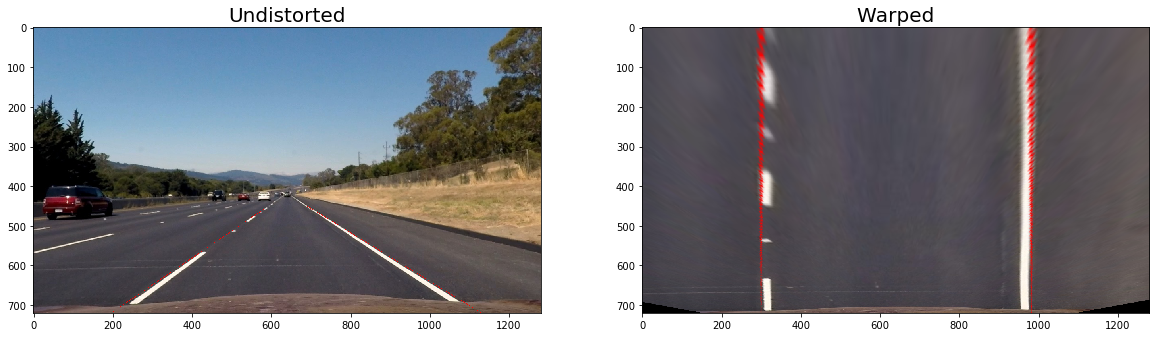

In [7]:
img_straight2 = mpimg.imread('test_images/straight_lines2.jpg')
img_straight2 = cv2.undistort(img_straight2, mtx, dist, None, mtx)
img_straight2 = draw_straight_line(img_straight2)
warped_straight2, _, _ = perspective_transform(img_straight2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(img_straight2)
ax1.set_title('Undistorted', fontsize=20)
ax2.imshow(warped_straight2)
ax2.set_title('Warped', fontsize=20)

In [8]:
# Read the list of test binary images, generate the binary warped images
images_binary = glob.glob('./output_images/test_images/binary_test*.jpg')

for idx, fname in enumerate(images_binary):
    img = mpimg.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    warped, _, _ = perspective_transform(img)
    
    write_name = './output_images/test_images/'+'binary_warped'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, warped, cmap='gray')

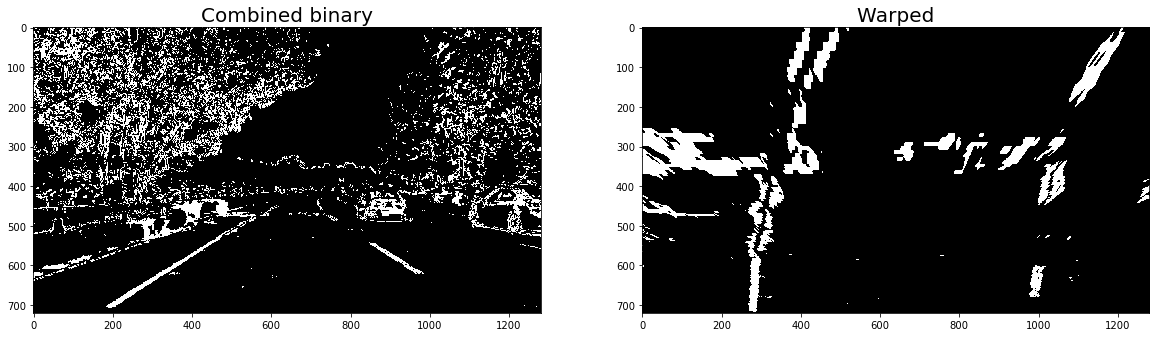

In [44]:
img_binary = combined_test
img_binary_warped, M, Minv = perspective_transform(img_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(img_binary, cmap='gray')
ax1.set_title('Combined binary', fontsize=20)
ax2.imshow(img_binary_warped, cmap='gray')
ax2.set_title('Warped', fontsize=20)

## Identify lane-line pixels and fit their positions with a polynomial


In [10]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
# define left and right lines for detection
left_line = Line()
right_line = Line()

In [32]:
# Set the width of the windows +/- margin
margin = 100

def find_line_histogram(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds
    

def plot_slide_window(out_img, left_fit, right_fit):    
        
    # Visualization
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
       
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    
def find_line_from_prev(binary_warped, left_fit, right_fit):
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
      
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def plot_poly_lane(out_img, left_fit, right_fit):
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    
    # Visualization
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

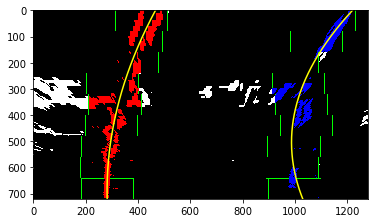

In [45]:
out_img, left_fit, right_fit, left_lane_inds, right_lane_inds = find_line_histogram(img_binary_warped)
plot_slide_window(out_img, left_fit, right_fit)

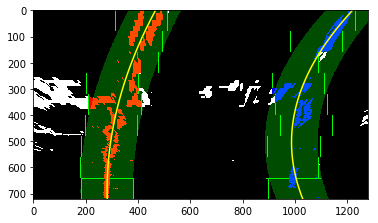

In [46]:
plot_poly_lane(out_img, left_fit, right_fit)

## Calculation of radius of curvature after correcting for scale in x and y.
Assuming that the lane is about 30 meters long and 3.7 meters wide.

In [35]:
def radius_of_curvature(img, left_lane_inds, right_lane_inds):
    
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=300 for left, and x=980 for right)
    leftx = np.array([300 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
    rightx = np.array([980 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/(980-300) # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    radius_curverad = (left_curverad + right_curverad)/2
    
    # Calculate the offset distance 
    left_x_eval = left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*(y_eval*ym_per_pix) + left_fit_cr[2]
    right_x_eval = right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*(y_eval*ym_per_pix) + right_fit_cr[2]
    offset_distance = 1280./2*xm_per_pix - (left_x_eval + right_x_eval)/2
    
    return left_curverad, right_curverad, offset_distance

## Draw the image of lane result plotted back down onto the road.

In [53]:
def plot_lane_on_image(img, left_fit, right_fit):
    
    # Get the current line fit values
    # left_fit = left_line.current_fit
    # right_fit = right_line.current_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result

def plot_radius_of_curvature(undistorted, left_fit, right_fit, left_lane_inds, right_lane_inds):
    
    result = plot_lane_on_image(undistorted, left_fit, right_fit)
    left_curverad, right_curverad, offset_distance = radius_of_curvature(undistorted, left_lane_inds, right_lane_inds)
        
    # Print Radius of Curvature and Offset Distance on the lane result 
    font = cv2.FONT_HERSHEY_SIMPLEX
    if left_curverad and right_curverad:
        str1 = str('Radius of Curvature: '+ str(round((left_curverad + right_curverad)/2, 5)) +'m')
        cv2.putText(result,str1,(430,600), font, 1,(0,0,255),2,cv2.LINE_AA)
        str2 = str('Offset Distance: '+ str(round(offset_distance, 5)) + 'm')
        cv2.putText(result,str2,(430,650), font, 1,(0,0,255),2,cv2.LINE_AA)
    
    return result

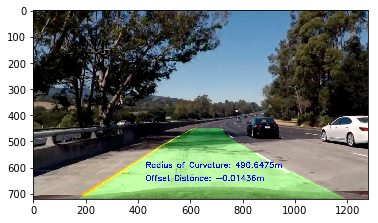

In [54]:
# Plot the Radius of Curvature and Offset Distance on the test image
result = plot_radius_of_curvature(image_undistorted, left_fit, right_fit, left_lane_inds, right_lane_inds)
plt.imshow(result)

In [55]:
# Detect lane pipeline
def detect_lane_pipeline(img):
    # Undistort the original image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    # Binary gradient of the undistorted image
    combined_binary, _, _, _, _, _ = combined_thresh(undistorted)
    # Perspective transform of the binary image
    binary_warped, _, _ = perspective_transform(combined_binary)
    # Find lane from the perspective transform image
    out_img, left_fit, right_fit, left_lane_inds, right_lane_inds = find_line_histogram(binary_warped)
    # Plot the lane result back to the undistorted image
    result = plot_radius_of_curvature(undistorted, left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    return result

# Read the list of test images
undistorted_images = glob.glob('./output_images/test_images/undistorted*.jpg')

for idx, fname in enumerate(undistorted_images):
    img = mpimg.imread(fname)
    test_result = detect_lane_pipeline(img)

    write_name = './output_images/test_images/'+'result'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, test_result)

# Pipeline (test videos)
## Video processing

Try the first project test video.

In [51]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(detect_lane_pipeline)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:36<00:00,  4.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 5min 37s


In [52]:
video_output = 'challenge_video_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
clip = clip1.fl_image(detect_lane_pipeline)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_result.mp4
[MoviePy] Writing video challenge_video_result.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:11<00:00,  3.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_result.mp4 

Wall time: 2min 12s
